# Load Environment

In [83]:
%load_ext autoreload
%autoreload 2
%pylab
from IPython.display import set_matplotlib_formats
%matplotlib inline
%config InlineBackend.figure_format='svg'
import seaborn
seaborn.reset_orig()
from matplotlib import rcParams
rcParams['figure.figsize'] = 10, 4

import numpy as np
from optalg.opt_solver import *
import scipy.io # to read matlab files

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
Using matplotlib backend: MacOSX
Populating the interactive namespace from numpy and matplotlib


`%matplotlib` prevents importing * from pylab and numpy


In [84]:
from mppfnet.mp_network import MPNetwork
from mppfnet.mp_problem import MPProblem
import mppfnet
import gridopt
import pfnet

# Load Network
Construct multi-period network and load topology

In [85]:
mp = MPNetwork(timesteps=24)
mp.load('./data/case32.art')

## Set Prices
Load EEX prices from a `.mat` file and set the bus prices accordingly.

In [86]:
prices = scipy.io.loadmat('./data/eex_intraday_2010_3600s.mat')['eex_intraday_2010_3600s']
eex_prices = np.array([p[0,0] for p in prices[:, 5][1:]])
mp.set_prices(eex_prices)

## Set Load Profiles
Read load profiles form a `.csv` generated with [ALPG](https://github.com/GENETX/alpg).

In [87]:
mp.load_load_profile_from_csv("./data/Electricity_Profile.csv")

## Set Solar Profiles
Generates and sets solar profiles from [PVWatts](http://pvwatts.nrel.gov/)

In [88]:
mp.generate_solar_profiles()

# Optimization Problem

Define bus voltage angles as variables (except the slack bus)

In [89]:
mp.set_flags(pfnet.OBJ_BUS, pfnet.FLAG_VARS, pfnet.BUS_PROP_NOT_SLACK, pfnet.BUS_VAR_VANG)

Set batteries power $P$ and energy $E$ as variables

In [90]:
mp.set_flags(pfnet.OBJ_BAT, pfnet.FLAG_VARS,pfnet.BAT_PROP_ANY, pfnet.BAT_VAR_E)
mp.set_flags(pfnet.OBJ_BAT, pfnet.FLAG_VARS,pfnet.BAT_PROP_ANY, pfnet.BAT_VAR_P)

Set generator powers as variables

In [91]:
mp.set_flags(pfnet.OBJ_GEN, pfnet.FLAG_VARS, pfnet.GEN_PROP_NOT_SLACK,pfnet.GEN_VAR_P)

Set the active power at the slack bus as a variable

In [92]:
mp.set_flags(pfnet.OBJ_GEN, pfnet.FLAG_VARS, pfnet.GEN_PROP_SLACK,pfnet.GEN_VAR_P)

Set the active power of the generators as an optimization variable

In [93]:
mp.set_flags(pfnet.OBJ_GEN,pfnet.FLAG_BOUNDED,pfnet.GEN_PROP_ANY,pfnet.GEN_VAR_P)

Set the power $P$ and the energy $E$ of the battery as bounded

In [94]:
mp.set_flags(pfnet.OBJ_BAT,pfnet.FLAG_BOUNDED,pfnet.BAT_PROP_ANY,pfnet.BAT_VAR_P)
mp.set_flags(pfnet.OBJ_BAT,pfnet.FLAG_BOUNDED,pfnet.BAT_PROP_ANY,pfnet.BAT_VAR_E)

## Construct the optimization problem

In [95]:
p = MPProblem(mp)

Add the netcon cost function:
$$f(x) = c_e \cdot (l + p_c + p_d - r)$$

In [96]:
p.add_function(pfnet.FUNC_TYPE_NETCON_COST, 1.0)

Generator Bounds

In [97]:
p.add_constraint(pfnet.CONSTR_TYPE_LBOUND)

DC Power Flow

In [98]:
p.add_constraint(pfnet.CONSTR_TYPE_DCPF)

Battery Dynamics Constraints

In [99]:
p.add_constraint(mppfnet.CONSTR_TYPE_BAT_DYN)

Analyse the Problem, set the initial point and evaluate the initial point $x_0$

In [100]:
p.analyze()
x = p.get_init_point()
x = p.eval(x)

Show some information about the network:

In [101]:
mp.show_components()

Network Components
-----------------------------
timesteps:           : 24
------- per timestep --------
buses:               : 31
   slack:            : 1
   reg by gen:       : 1
   reg by tran:      : 1
   reg by shunt:     : 0
shunts:              : 0
   fixed:            : 0
   switched v:       : 0
branches:            : 30
   lines:            : 29
   fixed trans:      : 0
   phase shifters    : 0
   tap changers v    : 1
   tap changers Q    : 0
generators:          : 1
   slack:            : 1
   reg:              : 1
   P adjust          : 1
loads:               : 19
   P adjust:         : 0
vargens:             : 2
batteries:           : 3


# Construct optimization problem for linear solver

In [102]:
from optalg.opt_solver.lp_cvxopt import OptSolverLP_CVXOPT
from optalg.opt_solver.linear_problem import LinProblem
from scipy.sparse import triu

In [103]:
Hx = p.Hphi + p.Hphi.T - triu(p.Hphi)
gx = p.gphi - Hx*x
g = gx / mp.base_power
H = Hx / mp.base_power
A = p.A
b = p.b
l = p.l
u = p.u
x = p.x

In [104]:
problem = QuadProblem(H, g, A, b, l, u, x=x)
solver = OptSolverIQP()
solver.set_parameters({'quiet': False, 'tol': 1e-4})
problem.show()

Solve Optimization Problem

In [105]:
solver.solve(problem)
print(solver.get_status())


Solver: IQP
-----------
iter    phi      fmax      gmax       cu       cl       s    
 0  2.25e+01  5.74e+01  9.90e+03  1.0e+01  1.0e+01  0.0e+00 
 1  2.25e+01  5.74e+01  9.90e+03  1.0e+01  1.0e+01  2.1e-06 
 2  2.25e+01  5.74e+01  9.90e+03  1.0e+01  1.0e+01  3.4e-06 
 3  2.25e+01  5.74e+01  9.90e+03  1.0e+01  1.0e+01  9.1e-06 
 4  2.25e+01  5.74e+01  9.90e+03  1.0e+01  1.0e+01  2.0e-05 
 5  2.25e+01  5.74e+01  9.90e+03  1.0e+01  1.0e+01  7.3e-05 
 6  2.25e+01  5.74e+01  9.90e+03  1.0e+01  1.0e+01  2.2e-04 
 7  2.25e+01  5.73e+01  9.89e+03  1.0e+01  1.0e+01  1.1e-03 
 8  2.21e+01  5.64e+01  9.74e+03  9.8e+00  9.8e+00  1.5e-02 
 9  2.19e+01  5.58e+01  9.63e+03  9.7e+00  9.7e+00  1.1e-02 
10  2.05e+01  5.22e+01  9.01e+03  9.1e+00  9.1e+00  6.4e-02 
11  1.74e+01  4.44e+01  7.67e+03  7.8e+00  7.8e+00  1.5e-01 
12  1.09e+01  2.78e+01  4.79e+03  4.9e+00  4.9e+00  3.8e-01 
13  2.82e+00  7.14e+00  1.23e+03  1.3e+00  1.3e+00  7.4e-01 
14  2.91e-02  1.37e-02  5.16e+00  1.0e-01  1.1e-01  1.0e+00

Store Solver Result

In [106]:
mp.set_var_values(solver.get_primal_variables())

# Output

In [107]:
%aimport pfvis

## Battery SOC

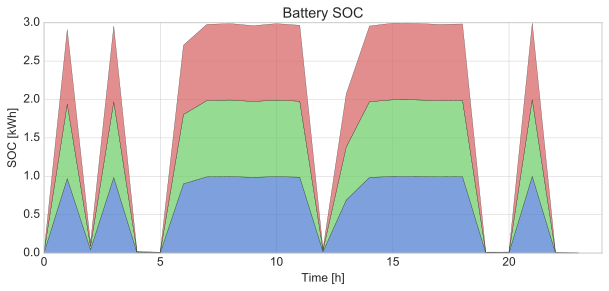

In [108]:
pfvis.plot_battery_soc(mp)

## Battery Power

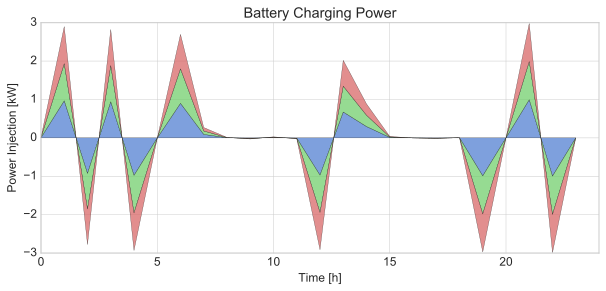

In [109]:
pfvis.plot_battery_power(mp)

## Energy Price

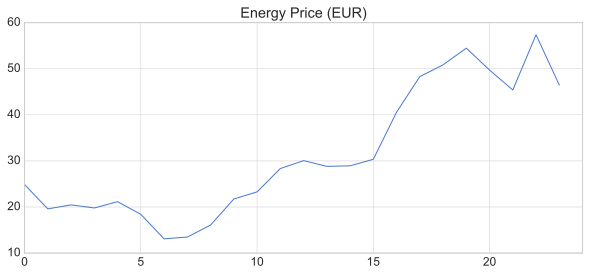

In [110]:
pfvis.plot_energy_price(mp)

## Load Power

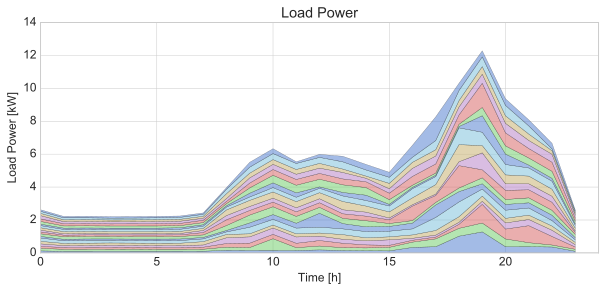

In [111]:
pfvis.plot_load_power(mp)

## Injection by renewable Generation

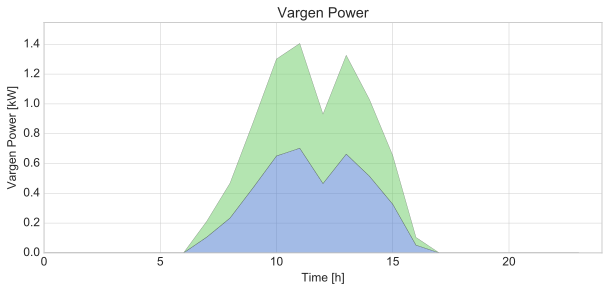

In [112]:
pfvis.plot_vargen_injection(mp)

## Network Graph

In [113]:
#g = pfnet.Graph(mp.networks[0])
#for bus in mp.networks[0].buses:
#    g.set_node_property(bus,b"label",str(bus.number).encode('UTF-8'))
#    g.set_node_property(bus,b"color",("red" if len(bus.bats) else "black").encode('UTF-8'))

#g.set_layout()    
#g.view(inline=True)

# Distributed Approach

In [114]:
prob = p.problems[0]
prob.analyze()
constraint = prob.constraints[1]
constraint.A.shape

(31, 40)

In [115]:
net = prob.network
net.var_generators[0].index_P

0

Show the structure of $A$

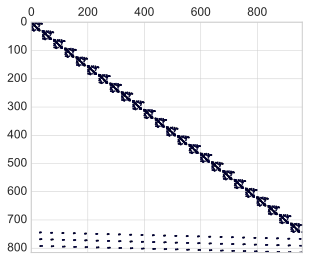

In [116]:
spy(A, precision=0.01, markersize=1)
show()

## Solve Benchmark Centralized QP Problem

In [117]:
nx = A.shape[1]
nc = A.shape[0]

print("Shape of A: {0}".format(A.shape))
print("Shape of b: {0}".format(b.shape))
print("Shape of g: {0}".format(g.shape))
print("Shape of H: {0}".format(H.shape))
print("Shape of l: {0}".format(l.shape))
print("Shape of u: {0}".format(u.shape))

Shape of A: (816, 960)
Shape of b: (816,)
Shape of g: (960,)
Shape of H: (960, 960)
Shape of l: (960,)
Shape of u: (960,)


Set the initial point $x_0$ to be all zeros (flat start)

In [118]:
x = zeros((nx,))

Construct the quadratic problem from $H, g, A, b, l$ and $u$ matricies constructed before

In [119]:
problem = QuadProblem(H, g, A, b, l, u, x=x)
solver = OptSolverIQP()
solver.set_parameters({'quiet': False, 'tol': 1e-4})

Solve the optimization problem and store the primal solution as $x^*$ and the optimal objective value as $p^*$

In [120]:
solver.solve(problem)
xstar = solver.get_primal_variables().copy()
pstar = np.dot(g,xstar)
print("Optimal objective value: {0:.2E} ".format(pstar))
#print(solver.get_dual_variables()[0])
#print(solver.get_primal_variables())


Solver: IQP
-----------
iter    phi      fmax      gmax       cu       cl       s    
 0  0.00e+00  5.74e+01  9.90e+03  1.0e+01  1.0e+01  0.0e+00 
 1  1.55e-03  5.74e+01  9.90e+03  1.0e+01  1.0e+01  2.1e-06 
 2  6.85e-03  5.74e+01  9.90e+03  1.0e+01  1.0e+01  8.4e-06 
 3  1.28e-02  5.74e+01  9.90e+03  1.0e+01  1.0e+01  1.8e-05 
 4  3.32e-02  5.74e+01  9.90e+03  1.0e+01  1.0e+01  1.1e-04 
 5  1.08e-02  5.73e+01  9.89e+03  1.0e+01  1.0e+01  6.0e-04 
 6  4.57e-02  5.72e+01  9.88e+03  1.0e+01  1.0e+01  1.7e-03 
 7  9.09e-03  5.70e+01  9.83e+03  9.9e+00  9.9e+00  4.7e-03 
 8  4.46e-02  5.61e+01  9.69e+03  9.8e+00  9.8e+00  1.4e-02 
 9  9.26e-03  5.37e+01  9.27e+03  9.4e+00  9.4e+00  4.3e-02 
10  4.45e-02  4.69e+01  8.10e+03  8.2e+00  8.2e+00  1.3e-01 
11  9.30e-03  2.98e+01  5.15e+03  5.2e+00  5.2e+00  3.6e-01 
12  4.45e-02  1.26e+00  2.17e+02  3.2e-01  3.2e-01  9.6e-01 

iter    phi      fmax      gmax       cu       cl       s    
12  4.45e-02  1.26e+00  3.06e+02  3.2e-01  3.2e-01  9.6e-

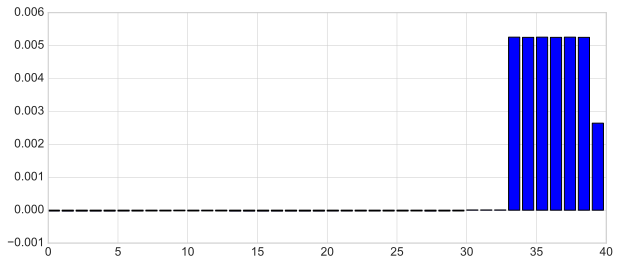

In [121]:
bar(range(mp.networks[0].num_vars), solver.get_primal_variables()[:mp.networks[0].num_vars])
show()

Construct the decoupled subproblem with the DC power balance relaxed in the objective:
    
$$
    \begin{align}\min &&& f(x) \\
    s.t. & && A x = b \\
     & && x_1, \ldots x_n \in \mathcal X_1, \ldots \mathcal X_n
    \end{align}
    $$

In [122]:
import cvxpy
from scipy.sparse import triu,coo_matrix,bmat,eye

# construct decoupled problem
# dc power flow constraints
A = scipy.sparse.block_diag([prob.constraints[1].A for prob in p.problems.values()])
b = np.hstack([prob.constraints[1].b for prob in p.problems.values()])
print("Shape of A: {0}".format(A.shape))
print("Shape of b: {0}".format(b.shape))

# battery dynamics
Abat = scipy.sparse.vstack([p.get_battery_A(battery) for battery in p.net.get_network().batteries])
bbat = np.hstack([p.get_battery_b(battery) for battery in p.net.get_network().batteries])
print("Shape of Abat: {0}".format(Abat.shape))
print("Shape of bbat: {0}".format(bbat.shape))
print("Shape of x: {0}".format(x.shape))

Shape of A: (744, 960)
Shape of b: (744,)
Shape of Abat: (72, 960)
Shape of bbat: (72,)
Shape of x: (960,)


## Dual Gradient Ascent

Initial Values:

In [123]:
lam = np.zeros(A.shape[0])  # really poor dual initial point
x = zeros((nx,)) # poor guess on the initial point

Parameters:

In [124]:
tol = 1e-5
mu = 1.799e-2

In [125]:
print("Solver: Dual Gradient")
print("----------------------------")
print("it  obj         alpha         lmin           lmax         dL/dl         deltax       error")
print("in  {1:.2E}      {2:.2E}         {3:.2E}      {4:.2E}     {5:.2E}      {6:.2E}     {7:.2E}".format(0, g.dot(x),  NaN, min(lam), max(lam),  norm(A*x -b), norm(x), np.abs(np.dot(g,x)-pstar)/np.abs(pstar)))


for iteration in range(1, 100):
    xprev = x.copy()
    
    alpha = 1 / (iteration + 1)

    # Primal update
    solver = OptSolverIQP()
    
    # Projection on the set
    QPproblem = QuadProblem(H+mu*A.T*A, g-A.T*lam-mu*A.T*b, Abat,bbat,l,u,x=x)
    solver.set_parameters({'quiet':True})
    solver.solve(QPproblem)
    x = solver.get_primal_variables()
    
    # Dual update
    lam += alpha * (b - A*x)
    
    # Print information
    if iteration % 1 == 0:
        print("{0}  {1:.2E}  {2:.2E}      {3:.2E}      {4:.2E}     {5:.2E}      {6:.2E}     {7:.2E}".format(iteration, g.dot(x),  alpha, min(lam), max(lam),  norm(A*x -b), norm(x - xprev), np.abs(np.dot(g,x)-pstar)/np.abs(pstar)))

    # Check for convergence
    if norm(A*x -b) < tol and np.abs(np.dot(g,x)-pstar)/np.abs(pstar) < tol:
        print("Converged")
        print("*  {1:.2E}  {2:.2E}      {3:.2E}      {4:.2E}     {5:.2E}      {6:.2E}     {7:.2E}".format(iteration, g.dot(x),  alpha, min(lam), max(lam),  norm(A*x -b), norm(x - xprev), np.abs(np.dot(g,x)-pstar)/np.abs(pstar)))
        break
        

Solver: Dual Gradient
----------------------------
it  obj         alpha         lmin           lmax         dL/dl         deltax       error
in  0.00E+00      NAN         0.00E+00      0.00E+00     7.61E-03      0.00E+00     1.00E+00
1  -1.68E-01  5.00E-01      -9.49E-08      2.09E-07     9.97E-06      6.91E-02     3.04E-09
Converged
*  -1.68E-01  5.00E-01      -9.49E-08      2.09E-07     9.97E-06      6.91E-02     3.04E-09


Plot a bar plot of $x$

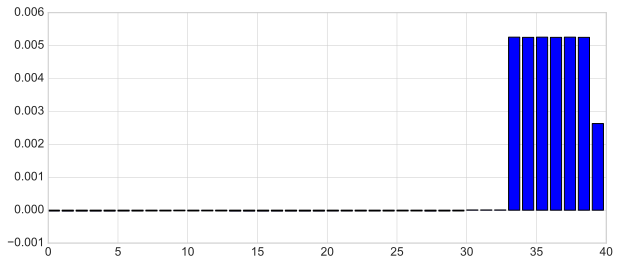

In [126]:
bar(range(mp.networks[0].num_vars), x[:mp.networks[0].num_vars])
show()

## Primal / Dual Gradient Method

In [ ]:
print("Solver: Primal/Dual Gradient")
print("----------------------------")
print("it   obj     alphax     alphal         lmin           lmax         dL/dx         dL/dl       deltax        error")

tol = 1e-5

# initial values
lam = np.zeros(A.shape[0])  # really poor dual initial point
x = p.get_init_point()
#x = zeros((nx,))

# scaling factor for augmented term
mu = 1e2
for iteration in range(1, 50000):
    xprev = x.copy()
    
    # gradient wrt. x
    gLx = g-A.T*lam-mu*A.T*b + (H+mu*A.T*A)*x
    # gradient wrt. lam
    gLl = b-A*x
    
    # step sizes
    alphax = 1 / (iteration+1e8)
    alphal = 1 / (iteration+1e10)
    
    y = x - alphax * gLx
    # do the projection

    solver = OptSolverIQP()
    QPproblem = QuadProblem(eye(nx),-2 * y, Abat,bbat,l,u,x=x)
    solver.set_parameters({'quiet':True})
    solver.solve(QPproblem)
    x = solver.get_primal_variables()
    
    lam = lam + alphal*gLl
   
    if iteration < 10 or iteration % 50 == 0:
        print("{0}  {1:.2E}  {2:.2E}   {3:.2E}  {4:.2E}      {5:.2E}     {6:.2E}      {7:.2E}     {8:.2E}      {9:.2E}".format(iteration, np.dot(g, x),  alphax, alphal, min(lam), max(lam), norm(gLx), norm(gLl), norm(x - xprev), np.abs(np.dot(g,x)-pstar)/np.abs(pstar)))
    if norm(A*x -b) < tol and np.abs(np.dot(g,x)-pstar)/np.abs(pstar) < tol:
        print("Converged")
        print("*  {1:.2E}  {2:.2E}   {3:.2E}  {4:.2E}      {5:.2E}     {6:.2E}      {7:.2E}     {8:.2E}      {9:.2E}".format(iteration, np.dot(g, x),  alphax, alphal, min(lam), max(lam), norm(gLx), norm(gLl), norm(x - xprev), np.abs(np.dot(g,x)-pstar)/np.abs(pstar)))
        break

## Required Communication

### Analysis for the problem without batteries

Since we use the augmented Lagrangian we need additional communication with not only the neighbouring nodes. To determine the additional communication requirements we inspect the structure of $A$.

We note that $A$ represents the DC power balance constraints and that $A$ is a Laplacian Matrix. For the following derivation we therefore denote the matrix containing the power blance as $L$ (to indicate its laplacian structure) and the adjacency matrix of the underlying graph $\hat A$ (not to be confused with $A$).

The Laplacian can be written as [[1]](http://www.sciencedirect.com/science/article/pii/0024379594904863):

$$L = D_{o} - \hat A$$

where $D_{o} = \text{diag} (d_{o})$ with $d_{o}$ being the vector of nodal out degrees.


Using this, we can write $A^\top A = A A$ (due to symmetry) as:
$$L L = (D_{o} D_{o} - D_{o} \hat A - \hat A D_{o} + \hat A \hat A$$
Using the diagonal structure of $D_o$ this simplifies to:
$$ L L = \text{diag} (d_o^2) - 2 \text{diag} (d_o) \hat A + \hat A \hat A$$
Inspecting this, we can see that the first term requires only local values and the second term is only a scaling of the values of the adjacent nodes.
$\hat A \hat A$ is the squared adjacency matrix, hence it is nonzero at $(i, j)$ if and only if $j$ is reachable from $i$ with 2 steps.

In [128]:
L = prob.constraints[1].A.tocsr()[:, :31]
do = array([len(bus.branches) for bus in mp.get_network().buses])
Do = diag(do)
Ahat = diag(do) - L
LL = Do * Do - 2 * Do * Ahat + Ahat * Ahat

In [129]:
count_nonzero(Ahat) - Ahat.shape[0] 

59

Additional communication exchanges:

In [130]:
count_nonzero(LL) - Ahat.shape[0] 

137

### Analysis for the problem with batteries

In [131]:
prob.constraints[1].A.tocsr().nnz

96

In [132]:
(prob.constraints[1].A.T * prob.constraints[1].A).nnz

229

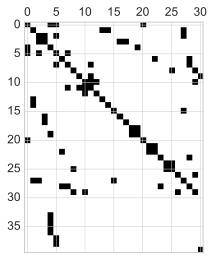

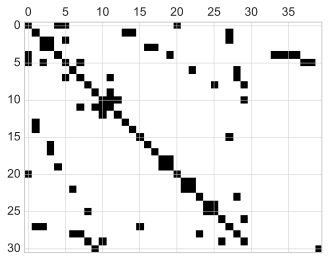

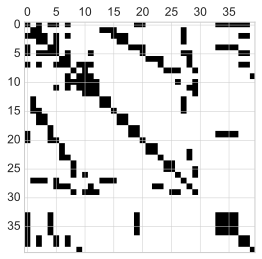

In [133]:
spy(prob.constraints[1].A.T.toarray())
show()
spy(prob.constraints[1].A.toarray())
show()
spy((prob.constraints[1].A.T * prob.constraints[1].A).toarray())
show()

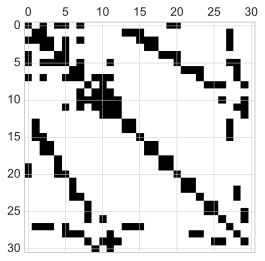

In [134]:
spy(LL)
show()

For the problem with batteries, we also need the net consumption of all neighbouring nodes when using the augmented Lagrangian.